## For each bee id, be able to provide the number of detections in the hive in the given timeslot.

In [24]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib
import math
import seaborn as sns
import numpy as np
import pandas as pd
import psycopg2
import psycopg2.extras
from datetime import timedelta, datetime
import time

import bb_utils
import bb_utils.meta
import bb_utils.ids
import bb_backend
from bb_backend.api import FramePlotter, VideoPlotter
from bb_backend.api import get_plot_coordinates, transform_axis_coordinates, get_image_origin

bb_backend.api.server_adress = 'localhost:8000'
connect_str = """dbname='beesbook' user='reader' host='tonic.imp.fu-berlin.de' 
                 password='' application_name='mehmed'"""

In [109]:
#Parameters for loading data
num_hours = 24
datetime_start = datetime(2016, 8, 23)

#Parameters for presenting data
bin_size_in_hours = 1

#Hyperparameters for the data wrangling process
num_intervals_per_hour = 120
rolling_window_size = 7


print(datetime_start)
#(First detections are on 20.07.2016, last are 19.09.2016 (3 months duration))

2016-08-23 00:00:00


In [110]:
#Define bee IDs by getting a known forager group
meta = bb_utils.meta.BeeMetaInfo()

group_id = 20
bee_ids_from_group = map(lambda i: i.as_ferwar(), 
                list(map(bb_utils.ids.BeesbookID.from_dec_12, meta.get_foragergroup(group_id).dec12)))

bee_ids_from_group = list(bee_ids_from_group)
group = meta.get_foragergroup(group_id)
print(group.date)

2016-08-23 00:00:00


### Reading from saved CSV files

In [111]:
# def clean_detections(csv:
    

In [112]:
#for testing: a single csv with hardcoded name
#sample_df = pd.read_csv('2016-08-23_00:00:00.csv', parse_dates=['timestamp'])

location_prefix = "/mnt/storage/janek/" # or ""

#Loading first element before the loop, to have a table formatted nicely for appending
start_csv_name = (datetime_start).strftime("%Y-%m-%d_%H:%M:%S")+".csv"

print('Processing '+location_prefix+start_csv_name+' before the loop')
detections_df = pd.read_csv(location_prefix+start_csv_name, parse_dates=['timestamp'], usecols=['timestamp', 'bee_id'])

detections_df.head()

Processing /mnt/storage/janek/2016-08-23_00:00:00.csv before the loop


,timestamp,bee_id
0,2016-08-23 00:27:31.780472,3073
1,2016-08-23 00:27:32.116578,3073
2,2016-08-23 00:27:32.447851,3073
3,2016-08-23 00:27:32.783652,3073
4,2016-08-23 00:27:33.109483,3073


In [113]:
#read and concat a number of hour-long csvs (note: thekla memory crashes if >16)
for i in range(1, num_hours):
    csv_name = (datetime_start + timedelta(hours=i)).strftime("%Y-%m-%d_%H:%M:%S")+".csv"
    print('Processing '+csv_name)
    new_data = pd.read_csv(location_prefix+csv_name, parse_dates=['timestamp'], usecols=['timestamp', 'bee_id'])
    detections_df = pd.concat([detections_df, new_data])
    print('Num. rows after appending: '+str(detections_df.shape[0]))

Processing 2016-08-23_01:00:00.csv
Num. rows after appending: 6795262
Processing 2016-08-23_02:00:00.csv
Num. rows after appending: 10195578
Processing 2016-08-23_03:00:00.csv
Num. rows after appending: 13643441
Processing 2016-08-23_04:00:00.csv
Num. rows after appending: 17171049
Processing 2016-08-23_05:00:00.csv
Num. rows after appending: 20520678
Processing 2016-08-23_06:00:00.csv
Num. rows after appending: 22617753
Processing 2016-08-23_07:00:00.csv
Num. rows after appending: 25885315
Processing 2016-08-23_08:00:00.csv
Num. rows after appending: 29422176
Processing 2016-08-23_09:00:00.csv
Num. rows after appending: 32896095
Processing 2016-08-23_10:00:00.csv
Num. rows after appending: 36475063
Processing 2016-08-23_11:00:00.csv
Num. rows after appending: 40180078
Processing 2016-08-23_12:00:00.csv
Num. rows after appending: 43288399
Processing 2016-08-23_13:00:00.csv
Num. rows after appending: 46654242
Processing 2016-08-23_14:00:00.csv
Num. rows after appending: 50162001
Process

In [114]:
print(detections_df.shape)

(80688851, 2)


In [115]:
#interval length is the total observation period divided by total number of intervals
total_num_intervals = (num_intervals_per_hour*num_hours)
interval_length = timedelta(hours=num_hours) // (num_intervals_per_hour*num_hours)

# prepare dataframe with zeros in the shape [bees x total_num_intervals]
# append bee_ids from the left
intervals = pd.DataFrame(data=np.zeros([len(bee_ids_from_group),total_num_intervals])) 
bee_ids = pd.DataFrame(data={'id': bee_ids_from_group})
presence_df = pd.concat([bee_ids, intervals], axis=1)

In [116]:
#Iterate over intervals and over detections
#If a bee from bee_ids is detected within a given interval, mark the cell for that bee and interval with a '1'

interval_starttime = datetime_start
# print("Processing intervals: ")
for interval in range(total_num_intervals): 
    #choose detections for interval
    interval_endtime = interval_starttime + interval_length
    before = detections_df['timestamp'] >= interval_starttime 
    after = detections_df['timestamp'] < interval_endtime
    interval_detections = detections_df[before & after]
    bee_row_number = 0
    for b in presence_df['id']:
        if b in interval_detections['bee_id'].unique():
            presence_df.set_value(bee_row_number, interval, 1)
        bee_row_number += 1 
    interval_starttime = interval_endtime
    #print(interval,", ", end='')

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:15: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  from ipykernel import kernelapp as app


In [117]:
#Apply rolling median to filter noise
#clean up to get rid of the NaNs
#use diff to identify entries (with 1) and exits (with -1)
#(sum_of_abs / 2) gives us the presumed number of trips a bee takes 

#'clean up nans'
num_nans_to_clean = math.floor(rolling_window_size/2)

first_col = presence_df.iloc[:, 1:2]
last_col = presence_df.iloc[:, -1:]


presence_temp = presence_df.iloc[:, 1:]
# presence = presence_df.iloc[:, 1:]
for i in range(0,num_nans_to_clean):
    presence_temp = pd.concat([first_col, presence_temp, last_col] ,axis=1)

rolled = presence_temp.rolling(window=rolling_window_size,center=True,axis=1).median()
rolled = rolled.iloc[:, num_nans_to_clean:-num_nans_to_clean]

In [118]:
rolled.head()

,0,1,2,3,4,5,6,7,8,9,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [134]:
diffed = rolled.diff(axis=1)
diffed.iloc[:,0] = np.zeros([11,1]) #clean out a column of NaNs 
diffed.head()

#a copy to be used to preview rolled + diffed presence 
#not actually used in further calculations (they are just based on 'diffed')
presence_df_copy = presence_df
presence_df_copy.iloc[:, 1:] = diffed 

trips_df = presence_df['id'] #for combining results in one table

In [135]:
presence_df_copy.head()

,id,0,1,2,3,4,5,6,7,8,...,2870,2871,2872,2873,2874,2875,2876,2877,2878,2879
0,1799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1593,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
2,2106,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1662,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [136]:
#for loop config
bin_starttime = datetime_start
num_intervals_per_bin = num_intervals_per_hour*bin_size_in_hours
total_num_bins = int(num_hours / bin_size_in_hours)

print("num_intervals_per_bin: ", num_intervals_per_bin, "total_num_bins: ", total_num_bins)
for bin_nr in range(total_num_bins): 
    
    start_index = bin_nr*num_intervals_per_bin
    end_index = start_index + num_intervals_per_bin
    
    new_bin = diffed.iloc[:, start_index:end_index]
    
    #limit down to the right bin:
    #read num_intervals_per_hour*bin_size_per_hour columns (as each column represents one interval)
    
    summed = new_bin.abs().sum(axis=1) / 2
    summed.name = bin_nr
    trips_df = pd.concat([trips_df,summed],axis=1) #add this interval to the trips table
    #update loop index

num_intervals_per_bin:  120 total_num_bins:  24


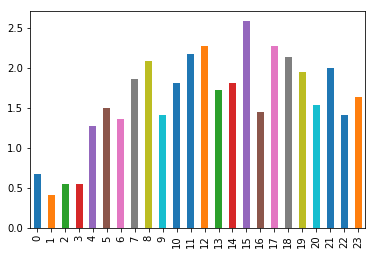

In [139]:
trips_ser = pd.Series(np.array(trips_df.mean(axis=0))[1:])
trips_ser.plot(kind='bar')
# trips_df

In [129]:
#saving (name still incomplete)
date_string = (datetime_start).strftime("%Y-%m-%d_%H:%M:%S")+".csv"
trips_df.to_csv('/mnt/storage/janek/'+'TRIPS-'+date_string+'-'+'h'+'.csv')